In [1]:
pwd

'C:\\Users\\User\\Desktop\\Data and Predictive Models'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from lightgbm import LGBMClassifier

In [2]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn import metrics

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

In [3]:
ccdata = pd.read_csv('BankChurners.csv')

In [4]:
ccdata.drop("CLIENTNUM",axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',axis=1,inplace=True)
ccdata['Gender'].replace({'M':1,'F':0},inplace=True)
ccdata["Attrition_Flag"].replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)
ccdata2 = pd.get_dummies(data=ccdata,columns=['Education_Level','Marital_Status',"Income_Category",'Card_Category'],drop_first=True)
ccdata2.drop(['Avg_Open_To_Buy','Customer_Age','Total_Trans_Ct','Months_on_book','Total_Amt_Chng_Q4_Q1'],axis=1,inplace=True)

In [5]:
X = ccdata2.drop("Attrition_Flag",axis=1)
y = ccdata2['Attrition_Flag']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

## hyperparameter optimization

In [53]:
lgbm_r = LGBMClassifier(application='binary')

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
parameter_grid = [
    {
        'n_estimators':np.arange(100,200,50),
        'boosting_type':['gbdt','rf','dart','goss'],
        'max_depth':np.arange(5,30,5),
        'min_data_in_leaf':np.arange(30,100,10),
        'num_leaves': np.arange(5,30,5)**2,
        'is_unbalance':['True','False']
    }
]

In [56]:
clf = GridSearchCV(lgbm_r, param_grid = parameter_grid, cv = 5, verbose = True, n_jobs = -1)

In [57]:
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 2800 candidates, totalling 14000 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.92367225 0.92367245 0.92367245 ... 0.93679459 0.93679459 0.93679459]
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


In [58]:
results = pd.DataFrame(clf.cv_results_)

In [59]:
best_clf.best_estimator_

LGBMClassifier(application='binary', is_unbalance='False', max_depth=5,
               min_data_in_leaf=60, n_estimators=150, num_leaves=100)

In [61]:
best_clf.best_score_

0.9445538907463572

In [48]:
best_clf.best_params_

{'boosting_type': 'gbdt',
 'max_depth': 5,
 'min_data_in_leaf': 60,
 'n_estimators': 150,
 'num_leaves': 100}

## testing

In [7]:
from lightmodule import lgbm
#lgbm module consists of
#classification report, confusion matrix, KPI_summary, training & testing predictive probabilities
#training and testing log loss, feature_importance

lightmodule.py is being imported into another module


In [22]:
light1 = lgbm(X_train,X_test,y_train,y_test)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


In [8]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm, y_sm = smote.fit_resample(X_train,y_train)

y_sm.value_counts()
#generate train test split first then do resampling only on training set

0    5949
1    5949
Name: Attrition_Flag, dtype: int64

In [9]:
##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train3, y_train3 = pipeline.fit_resample(X_train,y_train)
y_train3.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

## post-feature selection

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt          653
1       8             Total_Ct_Chng_Q4_Q1          368
2       5                    Credit_Limit          301
3       6             Total_Revolving_Bal          280
4       2        Total_Relationship_Count          192
5       4           Contacts_Count_12_mon          145
6       9           Avg_Utilization_Ratio          139
7       3          Months_Inactive_12_mon          126
8       1                 Dependent_count          101
9      16          Marital_Status_Married           45
10      0                          Gender           44
11     13   Education_Level_Post-Graduate           20
12     17           Marital_Status_Single           18
13     21    Income_Category_$80K - $120K           15
14     19     Income_Category_$40K - $60K           14
15     15         Education_Level_Unknown           12
16     18          Marital_Status_Unknown           12
17     22 

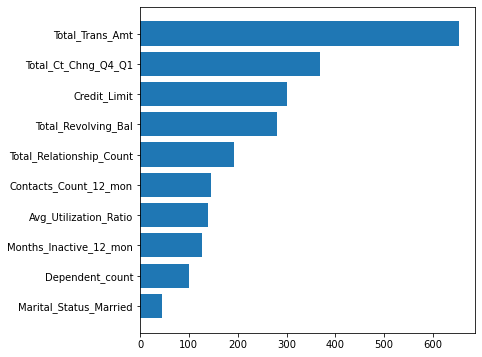

<Figure size 432x288 with 0 Axes>

In [23]:
light1.feature_importance()

In [10]:
PS_X_train = X_train.drop(['Gender',
                                 'Education_Level_Post-Graduate',
                                 'Marital_Status_Single',
                                 'Income_Category_$80K - $120K',
                                 'Income_Category_$40K - $60K',
                                 'Education_Level_Unknown',
                                 'Marital_Status_Unknown',
                                 'Income_Category_Less than $40K',
                                 'Education_Level_High School',
                                 'Education_Level_Doctorate',
                                 'Education_Level_Graduate',
                                 'Income_Category_$60K - $80K',
                                 'Education_Level_Uneducated',
                                 'Card_Category_Silver',
                                 'Income_Category_Unknown',
                                 'Card_Category_Gold',
                                 'Card_Category_Platinum'],
                                  axis = 1)

PS_X_test = X_test.drop(['Gender',
                         'Education_Level_Post-Graduate',
                         'Marital_Status_Single',
                         'Income_Category_$80K - $120K',
                         'Income_Category_$40K - $60K',
                         'Education_Level_Unknown',
                         'Marital_Status_Unknown',
                         'Income_Category_Less than $40K',
                         'Education_Level_High School',
                         'Education_Level_Doctorate',
                         'Education_Level_Graduate',
                         'Income_Category_$60K - $80K',
                         'Education_Level_Uneducated',
                         'Card_Category_Silver',
                         'Income_Category_Unknown',
                         'Card_Category_Gold',
                         'Card_Category_Platinum'],
                          axis = 1)

In [11]:
PS_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7088 entries, 4124 to 4752
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dependent_count           7088 non-null   int64  
 1   Total_Relationship_Count  7088 non-null   int64  
 2   Months_Inactive_12_mon    7088 non-null   int64  
 3   Contacts_Count_12_mon     7088 non-null   int64  
 4   Credit_Limit              7088 non-null   float64
 5   Total_Revolving_Bal       7088 non-null   int64  
 6   Total_Trans_Amt           7088 non-null   int64  
 7   Total_Ct_Chng_Q4_Q1       7088 non-null   float64
 8   Avg_Utilization_Ratio     7088 non-null   float64
 9   Marital_Status_Married    7088 non-null   uint8  
dtypes: float64(3), int64(6), uint8(1)
memory usage: 560.7 KB


In [12]:
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm2, y_sm2 = smote.fit_resample(PS_X_train,y_train)

y_sm2.value_counts()
#generate train test split first then do resampling only on training set

0    5949
1    5949
Name: Attrition_Flag, dtype: int64

In [13]:
##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train4, y_train4 = pipeline.fit_resample(PS_X_train,y_train)
y_train4.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

In [14]:
from lightmodule import lgbm,lgbm_unbalanced

light1 = lgbm(X_train,X_test,y_train,y_test)
light2 = lgbm(X_sm,X_test,y_sm,y_test)
light3 = lgbm(X_train3,X_test,y_train3,y_test)
light4 = lgbm(PS_X_train, PS_X_test,y_train,y_test)
light5 = lgbm(X_sm2, PS_X_test, y_sm2,y_test)
light6 = lgbm(X_train4, PS_X_test, y_train4,y_test)
light7 = lgbm_unbalanced(X_train,X_test,y_train,y_test)
light8 = lgbm_unbalanced(X_sm, X_test, y_sm, y_test)
light9 = lgbm_unbalanced(X_train3,X_test,y_train3,y_test)
light10 = lgbm_unbalanced(PS_X_train, PS_X_test,y_train,y_test)
light11 = lgbm_unbalanced(X_sm2, PS_X_test, y_sm2,y_test)
light12 = lgbm_unbalanced(X_train4, PS_X_test, y_train4,y_test)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min

In [15]:
ls10 = [light1,light2,light3,light4,light5,light6,light7,light8,light9,light10,light11,light12]
[print('light{}: '.format(i+1),x.f2_score) for i,x in enumerate(ls10)]

light1:  0.8333333333333334
light2:  0.8407798537774167
light3:  0.8546325878594248
light4:  0.8412567176519222
light5:  0.8564724286272977
light6:  0.8558558558558559
light7:  0.8793576184880533
light8:  0.8407798537774167
light9:  0.8642216152945768
light10:  0.8751458576429404
light11:  0.8564724286272977
light12:  0.8703136954858454


[None, None, None, None, None, None, None, None, None, None, None, None]

In [16]:
light7.KPI_summary()

accuracy score =  93.72 %
recall =  92.01 %
precision =  74.71 %
f2_score =  87.94 %
training accuracy =  95.67 %
testing accuracy =  93.72 %


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
    index                   Feature_names  Importances
0       7                 Total_Trans_Amt          684
1       8             Total_Ct_Chng_Q4_Q1          342
2       6             Total_Revolving_Bal          341
3       5                    Credit_Limit       

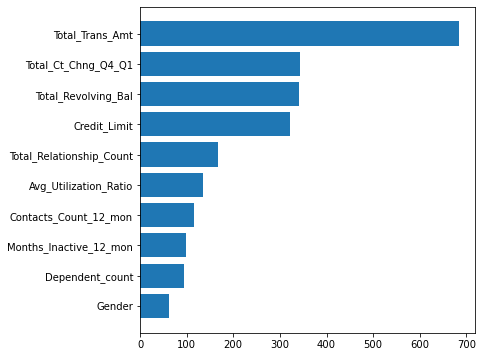



    index                   Feature_names  Importances
0       7                 Total_Trans_Amt          684
1       8             Total_Ct_Chng_Q4_Q1          342
2       6             Total_Revolving_Bal          341
3       5                    Credit_Limit          321
4       2        Total_Relationship_Count          168
5       9           Avg_Utilization_Ratio          135
6       4           Contacts_Count_12_mon          115
7       3          Months_Inactive_12_mon           99
8       1                 Dependent_count           94
9       0                          Gender           62
10     16          Marital_Status_Married           40
11     19     Income_Category_$40K - $60K           32
12     11        Education_Level_Graduate           32
13     22  Income_Category_Less than $40K           27
14     23         Income_Category_Unknown           27
15     17           Marital_Status_Single           26
16     12     Education_Level_High School           25
17     1

<Figure size 432x288 with 0 Axes>

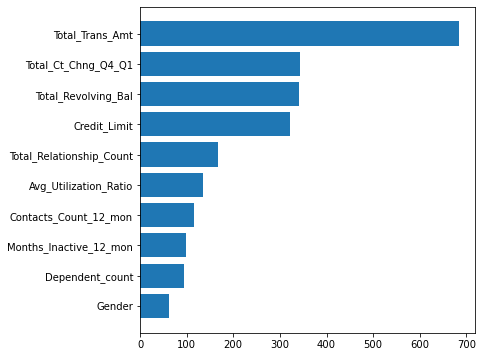



    index                   Feature_names  Importances
0       7                 Total_Trans_Amt          684
1       8             Total_Ct_Chng_Q4_Q1          342
2       6             Total_Revolving_Bal          341
3       5                    Credit_Limit          321
4       2        Total_Relationship_Count          168
5       9           Avg_Utilization_Ratio          135
6       4           Contacts_Count_12_mon          115
7       3          Months_Inactive_12_mon           99
8       1                 Dependent_count           94
9       0                          Gender           62
10     16          Marital_Status_Married           40
11     19     Income_Category_$40K - $60K           32
12     11        Education_Level_Graduate           32
13     22  Income_Category_Less than $40K           27
14     23         Income_Category_Unknown           27
15     17           Marital_Status_Single           26
16     12     Education_Level_High School           25
17     1

<Figure size 432x288 with 0 Axes>

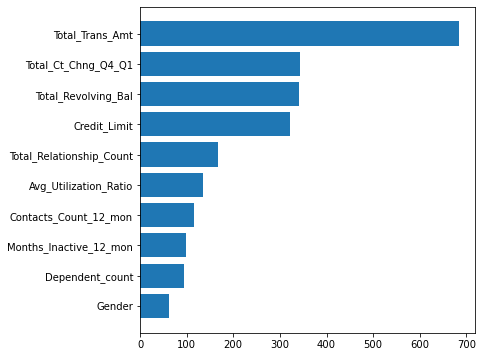



    index                   Feature_names  Importances
0       7                 Total_Trans_Amt          639
1       6             Total_Revolving_Bal          377
2       8             Total_Ct_Chng_Q4_Q1          331
3       5                    Credit_Limit          305
4       2        Total_Relationship_Count          172
5       9           Avg_Utilization_Ratio          132
6       4           Contacts_Count_12_mon          123
7       1                 Dependent_count          115
8       3          Months_Inactive_12_mon           94
9       0                          Gender           51
10     16          Marital_Status_Married           51
11     19     Income_Category_$40K - $60K           32
12     11        Education_Level_Graduate           30
13     17           Marital_Status_Single           29
14     22  Income_Category_Less than $40K           27
15     23         Income_Category_Unknown           24
16     21    Income_Category_$80K - $120K           23
17     1

<Figure size 432x288 with 0 Axes>

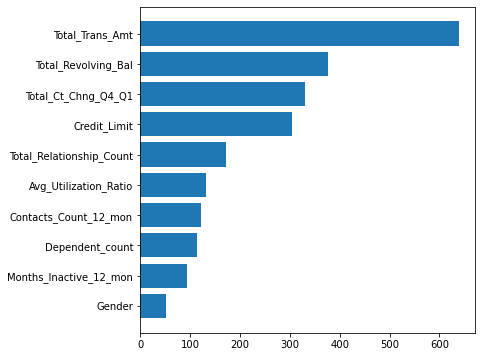



    index                   Feature_names  Importances
0       7                 Total_Trans_Amt          639
1       6             Total_Revolving_Bal          377
2       8             Total_Ct_Chng_Q4_Q1          331
3       5                    Credit_Limit          305
4       2        Total_Relationship_Count          172
5       9           Avg_Utilization_Ratio          132
6       4           Contacts_Count_12_mon          123
7       1                 Dependent_count          115
8       3          Months_Inactive_12_mon           94
9       0                          Gender           51
10     16          Marital_Status_Married           51
11     19     Income_Category_$40K - $60K           32
12     11        Education_Level_Graduate           30
13     17           Marital_Status_Single           29
14     22  Income_Category_Less than $40K           27
15     23         Income_Category_Unknown           24
16     21    Income_Category_$80K - $120K           23
17     1

<Figure size 432x288 with 0 Axes>

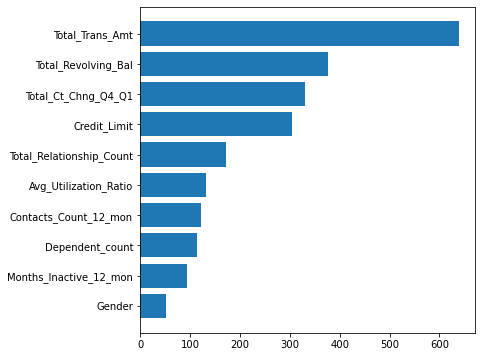



    index                   Feature_names  Importances
0       7                 Total_Trans_Amt          639
1       6             Total_Revolving_Bal          377
2       8             Total_Ct_Chng_Q4_Q1          331
3       5                    Credit_Limit          305
4       2        Total_Relationship_Count          172
5       9           Avg_Utilization_Ratio          132
6       4           Contacts_Count_12_mon          123
7       1                 Dependent_count          115
8       3          Months_Inactive_12_mon           94
9       0                          Gender           51
10     16          Marital_Status_Married           51
11     19     Income_Category_$40K - $60K           32
12     11        Education_Level_Graduate           30
13     17           Marital_Status_Single           29
14     22  Income_Category_Less than $40K           27
15     23         Income_Category_Unknown           24
16     21    Income_Category_$80K - $120K           23
17     1

<Figure size 432x288 with 0 Axes>

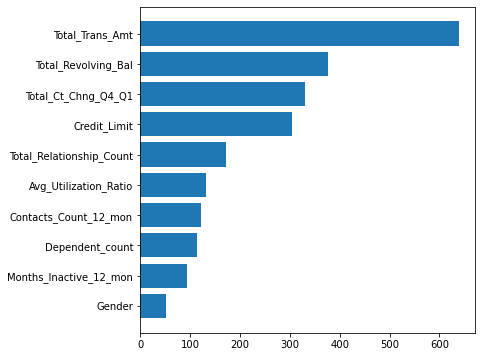

[None, None, None, None, None, None]

<Figure size 432x288 with 0 Axes>

In [24]:
light1 = lgbm(X_train,X_test,y_train,y_test)
light2 = lgbm(X_sm,X_test,y_sm,y_test)
light3 = lgbm(X_train3,X_test,y_train3,y_test)
light7 = lgbm_unbalanced(X_train,X_test,y_train,y_test)
light8 = lgbm_unbalanced(X_sm, X_test, y_sm, y_test)
light9 = lgbm_unbalanced(X_train3,X_test,y_train3,y_test)

ls10 = [light1,light2,light3,light7,light8,light9]
[x.feature_importance() for x in ls10]

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
   index             Feature_names  Importances
0      6           Total_Trans_Amt          752
1      5       Total_Revolving_Bal          361
2      7       Total_Ct_Chng_Q4_Q1          360
3      4              Credit_Limit          350
4      1  Total_Relationship

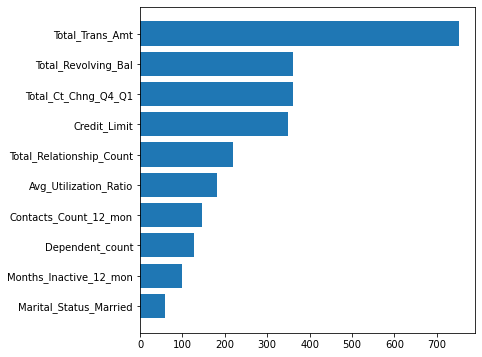



   index             Feature_names  Importances
0      6           Total_Trans_Amt          752
1      5       Total_Revolving_Bal          361
2      7       Total_Ct_Chng_Q4_Q1          360
3      4              Credit_Limit          350
4      1  Total_Relationship_Count          219
5      8     Avg_Utilization_Ratio          182
6      3     Contacts_Count_12_mon          145
7      0           Dependent_count          126
8      2    Months_Inactive_12_mon           98
9      9    Marital_Status_Married           58 



<Figure size 432x288 with 0 Axes>

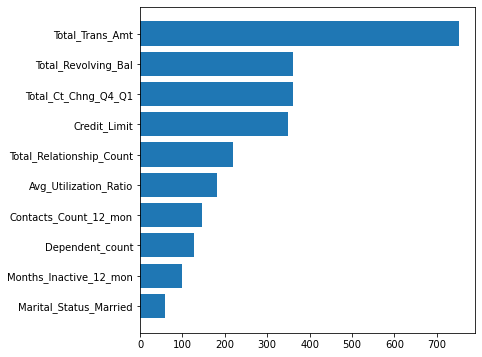



   index             Feature_names  Importances
0      6           Total_Trans_Amt          752
1      5       Total_Revolving_Bal          361
2      7       Total_Ct_Chng_Q4_Q1          360
3      4              Credit_Limit          350
4      1  Total_Relationship_Count          219
5      8     Avg_Utilization_Ratio          182
6      3     Contacts_Count_12_mon          145
7      0           Dependent_count          126
8      2    Months_Inactive_12_mon           98
9      9    Marital_Status_Married           58 



<Figure size 432x288 with 0 Axes>

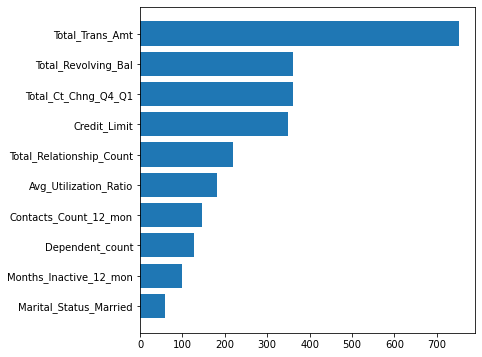



   index             Feature_names  Importances
0      6           Total_Trans_Amt          742
1      4              Credit_Limit          365
2      7       Total_Ct_Chng_Q4_Q1          360
3      5       Total_Revolving_Bal          331
4      1  Total_Relationship_Count          241
5      8     Avg_Utilization_Ratio          179
6      3     Contacts_Count_12_mon          150
7      0           Dependent_count          138
8      2    Months_Inactive_12_mon          106
9      9    Marital_Status_Married           64 



<Figure size 432x288 with 0 Axes>

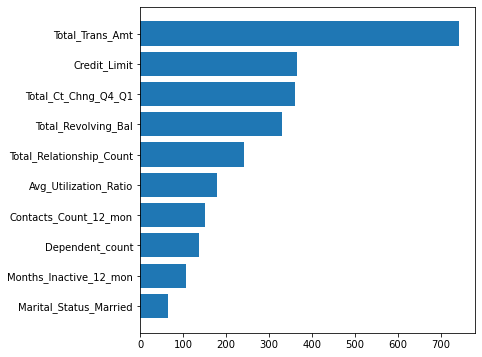



   index             Feature_names  Importances
0      6           Total_Trans_Amt          742
1      4              Credit_Limit          365
2      7       Total_Ct_Chng_Q4_Q1          360
3      5       Total_Revolving_Bal          331
4      1  Total_Relationship_Count          241
5      8     Avg_Utilization_Ratio          179
6      3     Contacts_Count_12_mon          150
7      0           Dependent_count          138
8      2    Months_Inactive_12_mon          106
9      9    Marital_Status_Married           64 



<Figure size 432x288 with 0 Axes>

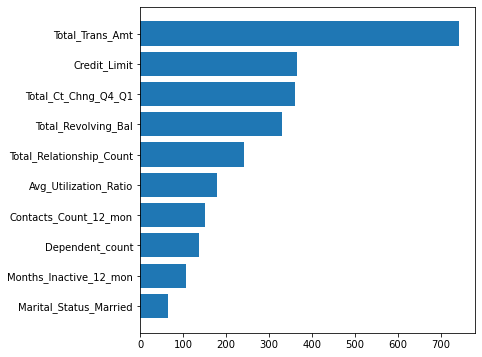



   index             Feature_names  Importances
0      6           Total_Trans_Amt          742
1      4              Credit_Limit          365
2      7       Total_Ct_Chng_Q4_Q1          360
3      5       Total_Revolving_Bal          331
4      1  Total_Relationship_Count          241
5      8     Avg_Utilization_Ratio          179
6      3     Contacts_Count_12_mon          150
7      0           Dependent_count          138
8      2    Months_Inactive_12_mon          106
9      9    Marital_Status_Married           64 



<Figure size 432x288 with 0 Axes>

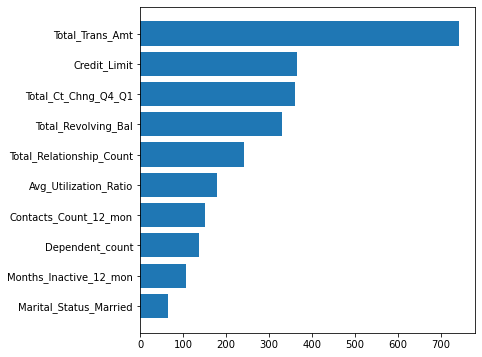

[None, None, None, None, None, None]

<Figure size 432x288 with 0 Axes>

In [25]:
light4 = lgbm(PS_X_train, PS_X_test,y_train,y_test)
light5 = lgbm(X_sm2, PS_X_test, y_sm2,y_test)
light6 = lgbm(X_train4, PS_X_test, y_train4,y_test)
light10 = lgbm_unbalanced(PS_X_train, PS_X_test,y_train,y_test)
light11 = lgbm_unbalanced(X_sm2, PS_X_test, y_sm2,y_test)
light12 = lgbm_unbalanced(X_train4, PS_X_test, y_train4,y_test)

ls11 = [light4,light5,light6,light10,light11,light12]

[x.feature_importance() for x in ls11]